In [1]:
import os
import json
import pandas as pd
import pandas_profiling
import numpy as np
from scipy import stats
from scipy.odr import Model, Data, ODR
import statsmodels.api as sm
from patsy import dmatrices
from matplotlib import pyplot as plt
import rpy2
import statsmodels.api as smapi
from statsmodels.formula.api import ols
import statsmodels.graphics as smgraphics

In [2]:
%matplotlib inline

# Statistical analysis of feature computations results


## Data importation and manipulation

In [3]:
def get_path_to_all_files(folder_name):
    """Recursively get all filepaths from a directory tree."""

    filepaths = []
    for dirname, dirnames, filenames in os.walk(folder_name):
        for filename in filenames:
            if '.DS_Store' not in filename:
                filepaths.append(os.path.join(dirname, filename))

    return filepaths

### Data importation


In [4]:
results_folder = "/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data"

In [5]:
files = get_path_to_all_files(results_folder)

#### Force plate feature data

In [6]:
fp_files = [file for file in files if "FP" in file]
fp_files[1:5]

['/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/1_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/2_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/3_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/4_3_cop_features.json']

#### Wii Balance Board feature data


In [7]:
wbb_files = [file for file in files if "FP" not in file]
wbb_files[1:5]

['/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/1_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/2_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/3_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/4_3_cop_features.json']

In [8]:
wbb_files_modified = [filename.replace("BB","FP") for filename in wbb_files]
fp_files_modified = [filename.replace("FP","BB") for filename in fp_files]

In [9]:
fp_files_curated = [file for file in fp_files if file in wbb_files_modified]
wbb_files_curated = [file for file in wbb_files if file in fp_files_modified]

In [10]:
print(fp_files_curated[1])
print(wbb_files_curated[1])
len(fp_files_curated)

/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/1_3_cop_features.json
/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/1_3_cop_features.json


72

In [11]:
identical_order_test = [i for i, j in zip(fp_files_curated, wbb_files_curated) if i == j.replace("BB","FP")]

In [12]:
if len(identical_order_test) == len(fp_files_curated):
    print("hello")

hello


###  Data manipulation

In [13]:
def create_index(df):
    arrays = [df["device"].values, df["subject"].values, 
             df["trial"].values, df["balance board"].values]
    tuples = list(zip(*arrays))
    return pd.MultiIndex.from_tuples(tuples, names=['device', 'subject','trial','balance board'])
    

In [14]:
def create_and_merge_dataframes(files):
    time_frames = []
    frequency_frames = []
    for filepath in files:
        with open(filepath) as json_data:
            features = json.load(json_data)     
            time_features = features["time_features"]
            frequency_features = features["frequency_features"]
            
            for dic in (time_features,frequency_features):
                dic["device"] = features["device"]
                dic["subject"] = features["subject"]
                dic["trial"] = features["trial"]
                dic["balance board"] = features["balance board"]

        time_frames.append(pd.DataFrame(time_features, index=[0]))
        frequency_frames.append(pd.DataFrame(frequency_features,index=[0]))
    
    time_features_df = pd.concat(time_frames, axis=0)    
    frequency_features_df = pd.concat(frequency_frames, axis=0)

    df1 = time_features_df.reset_index().drop(['device', 'subject','trial','balance board'], 1)
    df1.index = create_index(time_features_df)
    df1.drop('index', 1, inplace=True)
    df1.sort_index(inplace=True)
    
    df2 = frequency_features_df.reset_index().drop(['device', 'subject','trial','balance board'], 1)
    df2.index = create_index(frequency_features_df)
    df2.drop('index', 1, inplace=True)
    df2.sort_index(inplace=True)
    
    return (df1,df2)

####  WBB  features results merging

In [15]:
wbb_time, wbb_freq = create_and_merge_dataframes(wbb_files)

In [16]:
wbb_time.head()

Mean distance  Mean distance-ML  \
device subject trial balance board                                    
BB     1       1     1                   2.537978          0.895392   
                     2                   1.431951          0.688737   
                     3                   1.964288          0.694513   
                     4                   1.988220          0.675706   
               2     1                   2.910587          0.628287   

                                    Mean distance-AP  Rms distance  \
device subject trial balance board                                   
BB     1       1     1                      2.199606      2.836287   
                     2                      1.107175      1.696290   
                     3                      1.681636      2.248232   
                     4                      1.750502      2.369622   
               2     1                      2.761349      3.297010   

                                    Rms distance-ML  Rms distance-AP  \
device subject trial balance board                                     
BB     1       1     1                     1.137411         2.598234   
                     2                     0.911652         1.430485   
                     3                     0.867714         2.074035   
                     4                     0.791256         2.233612   
               2     1                     0.766301         3.206721   

                                       Range  Range-ML   Range-AP  \
device subject trial balance board                                  
BB     1       1     1              7.195700  6.152923  12.104959   
                     2              5.402505  6.279741   8.023026   
                     3              6.763312  3.303244  12.150626   
                     4              7.191346  4.060474  11.205422   
               2     1              6.582393  4.277345  13.134768   

                                    Mean velocity          ...           \
device subject trial balance board                         ...            
BB     1       1     1                  10.167939          ...            
                     2                   9.262958          ...            
                     3                   9.226852          ...            
                     4                  10.711853          ...            
               2     1                   9.581928          ...            

                                    Mean velocity-AP  Sway displacement  \
device subject trial balance board                                        
BB     1       1     1                      5.891463        5075.955110   
                     2                      5.552682        2863.902855   
                     3                      6.409622        3928.576781   
                     4                      6.918993        3976.439555   
               2     1                      5.558804        5821.173021   

                                    95% confidence circle area  \
device subject trial balance board                               
BB     1       1     1                               67.079591   
                     2                               26.930301   
                     3                               44.494449   
                     4                               53.041973   
               2     1                               93.599416   

                                    95% confidence elipse area  \
device subject trial balance board                               
BB     1       1     1                               86.692369   
                     2                               31.750938   
                     3                               54.498221   
                     4                               56.047405   
               2     1                              107.763725   

                                    Mean frequency  Mean frequency-ML  \
device 

In [17]:
wbb_freq.head()

Total power-RD  Total power-ML  \
device subject trial balance board                                   
BB     1       1     1                    1.109179        0.817033   
                     2                    0.581166        0.509629   
                     3                    0.986604        0.373030   
                     4                    1.270885        0.444072   
               2     1                    1.499483        0.414728   

                                    Total power-AP  Peak frequency-RD  \
device subject trial balance board                                      
BB     1       1     1                    2.911138               0.25   
                     2                    1.429343               0.15   
                     3                    2.792506               0.15   
                     4                    3.157431               0.20   
               2     1                    4.257377               0.15   

                                    Peak frequency-ML  Peak frequency-AP  \
device subject trial balance board                                         
BB     1       1     1                           0.20               0.20   
                     2                           0.15               0.20   
                     3                           0.15               0.15   
                     4                           0.15               0.15   
               2     1                           0.15               0.15   

                                    50% power frequency-RD  \
device subject trial balance board                           
BB     1       1     1                                0.40   
                     2                                0.45   
                     3                                0.50   
                     4                                0.50   
               2     1                                0.30   

                                    50% power frequency-ML  \
device subject trial balance board                           
BB     1       1     1                                0.55   
                     2                                0.40   
                     3                                0.30   
                     4                                0.65   
               2     1                                0.70   

                                    50% power frequency-AP  \
device subject trial balance board                           
BB     1       1     1                                0.25   
                     2                                0.35   
                     3                                0.30   
                     4                                0.35   
               2     1                                0.20   

                                    80% power frequency-RD  \
device subject trial balance board                           
BB     1       1     1                                0.90   
                     2                                1.10   
                     3                                1.00   
                     4                                1.10   
               2     1                                0.65   

                                             ...             \
device subject trial balance board           ...              
BB     1       1     1                       ...              
                     2                       ...              
                     3                       ...              
                     4                       ...              
               2     1                       ...              

                                    80% power frequency-AP  \
device subject trial balance board                           
BB     1       1     1                                0.45   
                     2                                0.80   
                     3                                0.70   
        

#### FP  features results merging

In [18]:
fp_time,fp_freq = create_and_merge_dataframes(fp_files)

In [19]:
fp_time.head()

Mean distance  Mean distance-ML  \
device subject trial balance board                                    
FP     1       1     1                   3.777345          1.346366   
                     2                   2.270832          1.102234   
                     3                   3.201574          1.176354   
                     4                   2.950853          1.043229   
               2     1                   4.292258          0.918233   

                                    Mean distance-AP  Rms distance  \
device subject trial balance board                                   
FP     1       1     1                      3.258812      4.231888   
                     2                      1.718943      2.695542   
                     3                      2.725414      3.720874   
                     4                      2.591341      3.493997   
               2     1                      4.070599      4.830667   

                                    Rms distance-ML  Rms distance-AP  \
device subject trial balance board                                     
FP     1       1     1                     1.698264         3.876181   
                     2                     1.460536         2.265564   
                     3                     1.478568         3.414490   
                     4                     1.276304         3.252547   
               2     1                     1.149082         4.692010   

                                        Range  Range-ML   Range-AP  \
device subject trial balance board                                   
FP     1       1     1              11.657688  8.559231  19.482437   
                     2               8.942371  9.253021  14.365417   
                     3              10.060940  6.841523  18.513464   
                     4              10.329302  7.020250  15.601356   
               2     1               9.469973  6.018384  18.592177   

                                    Mean velocity          ...           \
device subject trial balance board                         ...            
FP     1       1     1                   9.639131          ...            
                     2                   8.350548          ...            
                     3                   9.438455          ...            
                     4                  10.326902          ...            
               2     1                   8.773980          ...            

                                    Mean velocity-AP  Sway displacement  \
device subject trial balance board                                        
FP     1       1     1                      6.554753        7554.690560   
                     2                      6.542199        4541.664690   
                     3                      7.809214        6403.147268   
                     4                      7.600290        5901.705810   
               2     1                      5.995474        8584.515583   

                                    95% confidence circle area  \
device subject trial balance board                               
FP     1       1     1                              150.267317   
                     2                               68.219177   
                     3                              125.502610   
                     4                              114.177290   
               2     1                              197.958984   

                                    95% confidence elipse area  \
device subject trial balance board                               
FP     1       1     1                              199.562670   
                     2                               85.780875   
                     3                              157.278935   
                     4                              128.664944   
               2     1                              237.258257   

                                    Mean frequency  Mean frequency-ML  \


In [20]:
fp_freq.head()

Total power-RD  Total power-ML  \
device subject trial balance board                                   
FP     1       1     1                    2.522262        1.899801   
                     2                    1.503511        1.208584   
                     3                    2.871920        1.194198   
                     4                    2.723630        1.191517   
               2     1                    3.240418        0.980455   

                                    Total power-AP  Peak frequency-RD  \
device subject trial balance board                                      
FP     1       1     1                    6.438115               0.25   
                     2                    3.482607               0.15   
                     3                    7.414356               0.15   
                     4                    6.706982               0.20   
               2     1                    9.406464               0.15   

                                    Peak frequency-ML  Peak frequency-AP  \
device subject trial balance board                                         
FP     1       1     1                           0.20               0.20   
                     2                           0.15               0.25   
                     3                           0.15               0.15   
                     4                           0.15               0.15   
               2     1                           0.15               0.20   

                                    50% power frequency-RD  \
device subject trial balance board                           
FP     1       1     1                                0.40   
                     2                                0.65   
                     3                                0.45   
                     4                                0.50   
               2     1                                0.35   

                                    50% power frequency-ML  \
device subject trial balance board                           
FP     1       1     1                                0.55   
                     2                                0.30   
                     3                                0.35   
                     4                                0.65   
               2     1                                0.70   

                                    50% power frequency-AP  \
device subject trial balance board                           
FP     1       1     1                                0.25   
                     2                                0.40   
                     3                                0.30   
                     4                                0.35   
               2     1                                0.25   

                                    80% power frequency-RD  \
device subject trial balance board                           
FP     1       1     1                                 0.9   
                     2                                 1.3   
                     3                                 0.8   
                     4                                 1.0   
               2     1                                 0.7   

                                             ...             \
device subject trial balance board           ...              
FP     1       1     1                       ...              
                     2                       ...              
                     3                       ...              
                     4                       ...              
               2     1                       ...              

                                    80% power frequency-AP  \
device subject trial balance board                           
FP     1       1     1                                0.45   
                     2                                1.00   
                     3                                0.60   
        

#### Outlier detection study !!!
 

In [21]:
def get_outlier_identity(data, feature_name, balance_board_number):
    data = data.loc[data.index.get_level_values('balance board') == balance_board_number]
    outlier_values = data[data[feature_name]==data[feature_name].max()]

    return outlier_values.index

In [22]:
fp_outlier_index_1 = get_outlier_identity(fp_time,"Range","1")
fp_time.loc[fp_outlier_index_1]

,,,,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Range,Range-ML,Range-AP,Mean velocity,...,Mean velocity-AP,Sway displacement,95% confidence circle area,95% confidence elipse area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Sway area,Fractal dimension-CC,Fractal dimension-CE
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,,
FP,3,3,1,7.858964,3.779366,6.013704,11.112579,7.574633,8.131073,48.658268,59.866906,52.611034,26.755568,...,21.170642,15717.928161,1356.966134,1573.435591,0.541837,0.57366,0.622325,97.505131,1.506408,1.484633


In [23]:
wbb_outlier_index_1 = get_outlier_identity(wbb_time,"Range","1")
wbb_time.loc[wbb_outlier_index_1]

,,,,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Range,Range-ML,Range-AP,Mean velocity,...,Mean velocity-AP,Sway displacement,95% confidence circle area,95% confidence elipse area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Sway area,Fractal dimension-CC,Fractal dimension-CE
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,,
BB,3,3,1,4.631332,1.595232,4.07739,5.938478,2.586838,5.345446,19.365479,22.249704,30.153128,17.308596,...,13.89867,9262.663325,362.769436,412.413529,0.594807,0.68686,0.602582,29.827344,1.576417,1.555725


In [24]:
fp_outlier_values_2 = get_outlier_identity(fp_time,"Range-AP", "2")
fp_time.loc[fp_outlier_values_2]

,,,,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Range,Range-ML,Range-AP,Mean velocity,...,Mean velocity-AP,Sway displacement,95% confidence circle area,95% confidence elipse area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Sway area,Fractal dimension-CC,Fractal dimension-CE
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,,
FP,4,1,2,7.149279,3.171147,5.895878,12.239302,5.343472,11.011259,63.592448,41.430276,107.656082,36.722607,...,31.612449,14298.557994,1733.621352,1781.993656,0.817507,0.72484,0.947839,143.968391,1.566698,1.562267


In [25]:
wbb_outlier_values_2 = get_outlier_identity(wbb_time,"Range-AP", "2")
wbb_time.loc[wbb_outlier_values_2]

,,,,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Range,Range-ML,Range-AP,Mean velocity,...,Mean velocity-AP,Sway displacement,95% confidence circle area,95% confidence elipse area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Sway area,Fractal dimension-CC,Fractal dimension-CE
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,,
BB,4,1,2,4.247653,1.936201,3.487905,7.136496,3.29736,6.329059,37.655855,25.867529,65.607445,22.840691,...,18.48619,8495.305567,588.034233,604.485131,0.855816,0.771304,0.936932,48.649161,1.588219,1.583654


In [26]:
fp_outlier_values_3 = get_outlier_identity(fp_time,"Range-AP", "3")
fp_time.loc[fp_outlier_values_3]

,,,,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Range,Range-ML,Range-AP,Mean velocity,...,Mean velocity-AP,Sway displacement,95% confidence circle area,95% confidence elipse area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Sway area,Fractal dimension-CC,Fractal dimension-CE
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,,
FP,4,1,3,4.596324,1.754647,3.788536,6.424291,3.012152,5.674368,33.627187,27.290761,43.434586,14.398877,...,11.305921,9192.647803,450.85753,493.41166,0.498584,0.699183,0.527545,25.162154,1.486183,1.473193


In [27]:
wbb_outlier_values_3 = get_outlier_identity(wbb_time,"Range-AP", "3")
wbb_time.loc[wbb_outlier_values_3]

,,,,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Range,Range-ML,Range-AP,Mean velocity,...,Mean velocity-AP,Sway displacement,95% confidence circle area,95% confidence elipse area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Sway area,Fractal dimension-CC,Fractal dimension-CE
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,,
BB,4,1,3,4.51182,1.476089,3.939819,6.254796,2.222535,5.846607,21.573458,16.747269,41.470631,16.443406,...,12.569467,9023.640826,425.500141,434.295039,0.580043,0.888468,0.563982,27.902356,1.534711,1.531548


In [28]:
fp_outlier_values_4 = get_outlier_identity(fp_time,"Range", "4")
fp_time.loc[fp_outlier_values_4]

,,,,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Range,Range-ML,Range-AP,Mean velocity,...,Mean velocity-AP,Sway displacement,95% confidence circle area,95% confidence elipse area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Sway area,Fractal dimension-CC,Fractal dimension-CE
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,,
FP,1,3,4,9.366468,0.881612,9.244948,10.638099,1.137614,10.577097,23.004571,7.549925,43.536154,9.656341,...,7.28271,18732.935732,980.149701,1085.448694,0.16408,0.919881,0.139256,22.745646,1.28781,1.276773


In [29]:
wbb_outlier_values_4 = get_outlier_identity(wbb_time,"Range", "4")
wbb_time.loc[wbb_outlier_values_4]

,,,,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Range,Range-ML,Range-AP,Mean velocity,...,Mean velocity-AP,Sway displacement,95% confidence circle area,95% confidence elipse area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Sway area,Fractal dimension-CC,Fractal dimension-CE
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,,
BB,1,3,4,6.472372,0.559574,6.40481,7.343363,0.737924,7.306192,14.178287,3.225862,29.177317,9.595449,...,6.29937,12944.743972,465.966225,513.229744,0.235951,1.521076,0.173866,16.493267,1.372817,1.360943


In [30]:
wbb_outlier_values_4 = get_outlier_identity(wbb_freq,"Frequency dispersion-AP", "1")
wbb_freq.loc[wbb_outlier_values_4]

,,,,Total power-RD,Total power-ML,Total power-AP,Peak frequency-RD,Peak frequency-ML,Peak frequency-AP,50% power frequency-RD,50% power frequency-ML,50% power frequency-AP,80% power frequency-RD,...,80% power frequency-AP,95% power frequency-RD,95% power frequency-ML,95% power frequency-AP,Centroidal frequency-RD,Centroidal frequency-ML,Centroidal frequency-AP,Frequency dispersion-RD,Frequency dispersion-ML,Frequency dispersion-AP
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,,
BB,6,1,1,2.348624,0.505915,6.749486,0.2,0.15,0.15,0.25,0.5,0.2,0.45,...,0.25,1.45,2.15,0.7,0.660216,0.977115,0.406237,0.784959,0.73519,0.776116


#### Duplicates removal 



In [85]:
def get_duplicate_identity(data, balance_board_number):
    data = data.loc[data.index.get_level_values('balance board') == balance_board_number]

    return data[data.duplicated()==True].index.tolist()

In [87]:
wbb_duplicates_2 = get_duplicate_identity(wbb_time, "3")
wbb_duplicates_2


[('BB', '6', '3', '3')]

## Statistical analysis

### General descriptive statistics HTML reports 

In [31]:
wbb_time.head()
wbb_time.index.get_level_values(3)
wbb_time_1 = wbb_time.loc[(wbb_time.index.get_level_values(3)=="1")]

In [32]:
outputfile = "/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/notebooks/results/wbb_data_1_time_domain_report.html"
df_profile = pandas_profiling.ProfileReport(wbb_time_1, bins=50)
df_profile.to_file(outputfile=outputfile)

### Features mean value and standard deviation 

In [33]:
def compute_mean_and_stds(df1, df2):
    """Compute the mean and standard deviation values for each feature and each balance board."""

    wbb_and_fp_results = pd.concat([df1, df2], axis=0) 
    feature_mean_results= wbb_and_fp_results.groupby([wbb_and_fp_results.index.get_level_values(0),wbb_and_fp_results.index.get_level_values(3)]).mean().transpose().stack(0).unstack()
    feature_std_results= wbb_and_fp_results.groupby([wbb_and_fp_results.index.get_level_values(0),wbb_and_fp_results.index.get_level_values(3)]).std().transpose().stack(0).unstack()
    aggregated_results = (feature_mean_results, feature_std_results)
    
    return aggregated_results

In [34]:
time_mean_results, time_std_results = compute_mean_and_stds(wbb_time, fp_time)

In [35]:
time_mean_results.head()

balance board            1                   2                   3            \
device                  BB        FP        BB        FP        BB        FP   
Mean distance     2.691569  4.079869  2.801712  4.447553  2.446242  3.624795   
Mean distance-ML  0.799424  1.351167  0.948653  1.633254  0.859484  1.352633   
Mean distance-AP  2.409353  3.551843  2.442388  3.791304  2.120405  3.079424   
Rms distance      3.201760  4.942078  3.411789  5.428466  2.882147  4.265415   
Rms distance-ML   1.079940  1.943217  1.293925  2.241409  1.082239  1.746920   

balance board            4            
device                  BB        FP  
Mean distance     2.643725  3.919436  
Mean distance-ML  0.884243  1.360472  
Mean distance-AP  2.311315  3.381884  
Rms distance      3.024479  4.501319  
Rms distance-ML   1.069039  1.719881

### Spearman correlation

In [36]:
def compute_spearman_correlation(df1, df2):
    
    wbb_numbers = ["1", "2", "3", "4"]
    dfs_1 = [df1.loc[(df1.index.get_level_values(3) == number)] for number in wbb_numbers]
    dfs_1_mean = [df.groupby([df.index.get_level_values(0),df.index.get_level_values(1),\
                                  df.index.get_level_values(3)]).mean() for df in dfs_1]

    dfs_2 = [df2.loc[(df2.index.get_level_values(3) == number)] for number in wbb_numbers]
    dfs_2_mean = [df.groupby([df.index.get_level_values(0),df.index.get_level_values(1),\
                                  df.index.get_level_values(3)]).mean() for df in dfs_2]
    
    result_dict = {key:{} for key in df1.columns}
    
    for (df1, df2, number) in zip(dfs_1_mean, dfs_2_mean, wbb_numbers):
        # Loop over each feature
        for column in df1.columns:
            x = df1[column]
            y = df2[column]

            # Compute the spearman coefficient(rho) and the corresponding p-value
            rho, p_value = stats.spearmanr(x, y, nan_policy="propagate")

            # Store the results
            result_dict[column][number] = {}
            result_dict[column][number]["p-value"] = p_value
            result_dict[column][number]["rho"] = rho
            
    result_dict_collapsed = {(outer_k, inner_k): inner_v for outer_k in result_dict
               for inner_k, inner_v in result_dict[outer_k].items()}

    aggregated_results = pd.DataFrame.from_dict(result_dict_collapsed).transpose()
    aggregated_results = aggregated_results.unstack().stack(0).unstack()

    return aggregated_results

In [37]:
time_spearman_results = compute_spearman_correlation(wbb_time, fp_time)

In [38]:
time_spearman_results.head()

1                   2                   3  \
                             p-value       rho   p-value       rho   p-value   
95% confidence circle area  0.041563  0.828571  0.000000  1.000000  0.004805   
95% confidence elipse area  0.041563  0.828571  0.000000  1.000000  0.041563   
Fractal dimension-CC        0.041563  0.828571  0.004805  0.942857  0.110787   
Fractal dimension-CE        0.041563  0.828571  0.004805  0.942857  0.041563   
Mean distance               0.018845  0.885714  0.000000  1.000000  0.041563   

                                             4            
                                 rho   p-value       rho  
95% confidence circle area  0.942857  0.004805  0.942857  
95% confidence elipse area  0.828571  0.000000  1.000000  
Fractal dimension-CC        0.714286  0.041563  0.828571  
Fractal dimension-CE        0.828571  0.328723  0.485714  
Mean distance               0.828571  0.000000  1.000000

In [39]:
wbb_time.columns

Index(['Mean distance', 'Mean distance-ML', 'Mean distance-AP', 'Rms distance',
       'Rms distance-ML', 'Rms distance-AP', 'Range', 'Range-ML', 'Range-AP',
       'Mean velocity', 'Mean velocity-ML', 'Mean velocity-AP',
       'Sway displacement', '95% confidence circle area',
       '95% confidence elipse area', 'Mean frequency', 'Mean frequency-ML',
       'Mean frequency-AP', 'Sway area', 'Fractal dimension-CC',
       'Fractal dimension-CE'],
      dtype='object')

### Pearson's correlation coefficient and regression lines equations 


In [40]:
fp_time_cut = fp_time[:wbb_time.shape[0]]

#### Ordinary least square regression (OLS)

In [41]:
def plot_correlation(df1,df2,name="time_domain"):
    columns = df1.columns
    fig, axs = plt.subplots(3,7,figsize=(30,15),facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5)
    #axs[-1, -1].axis('off')
    for ax, column in zip(axs.ravel(), columns):
        x = df2[column]
        y = df1[column]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        ax.plot(x, y, '.', label='original data')
        ax.plot(x, intercept + slope*x, 'black', label='fitted line', linewidth=0.3)
        ax.set_xlabel('Force plate')

        ax.set_ylabel('Balance Board')
        ax.set_title(column, weight = 600)
        r_squared = round(r_value**2,4)
        ax.text(0.8, 0.4, "p-value = {}".format(round(p_value,4)), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        ax.text(0.8, 0.3, "R\u00b2={}".format(r_squared), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        ax.text(0.8, 0.2, "Slope = {}".format(round(slope,4)), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        ax.text(0.8, 0.1, "Intercept = {}".format(round(intercept,4)), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        #ax.legend()
    plt.tight_layout()
    plt.savefig("results/{}_correlation_plots.png".format(name), bbox_inches='tight')


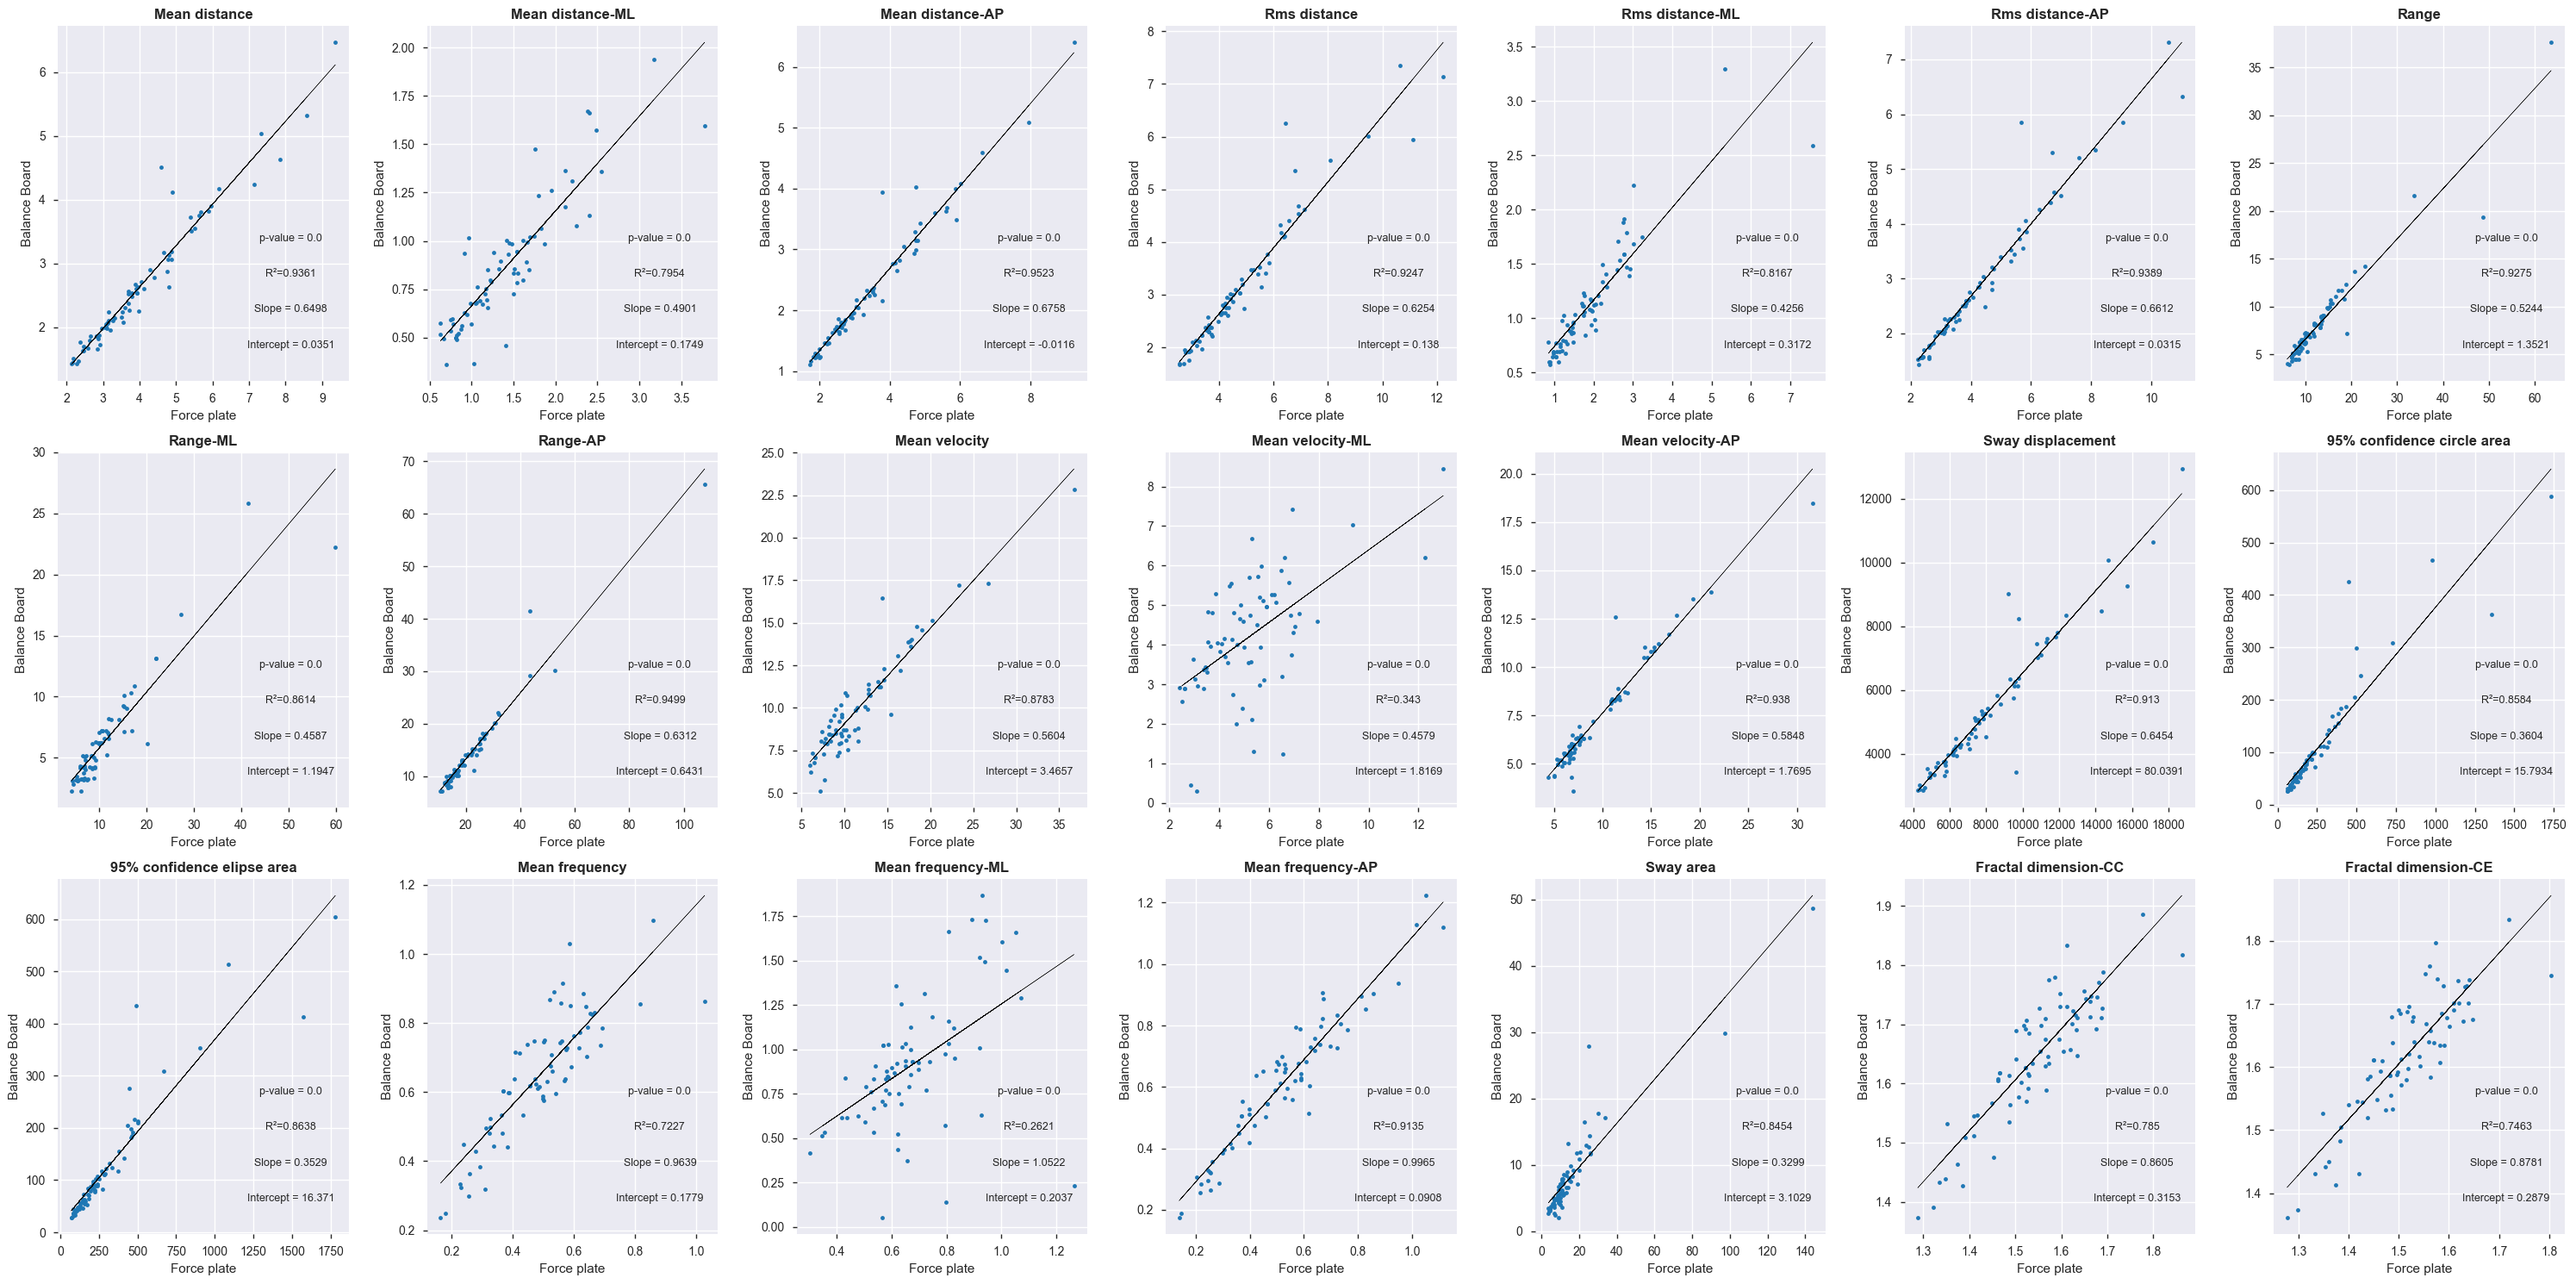

In [42]:
plot_correlation(wbb_time, fp_time_cut)

##### Use a diffrent library (statsmodels) FOR OLS

In [43]:
def plot_correlation_2(df1,df2):
    columns = df1.columns
    fig, axs = plt.subplots(6,3,figsize=(20,30),facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5)
    axs[-1, -1].axis('off')
    for ax, column in zip(axs.ravel(), columns):
        x = df1[column]
        y = df2[column]
        regression = ols("data ~ x", data=dict(data=y, x=x)).fit(covtype="scale")
        
        # Find outliers #
        test = regression.outlier_test()
        outliers = ((x[i],y[i]) for i,t in enumerate(test["unadj_p"]) if t < 0.5)
        #print ('Outliers: ', list(outliers))
        
        smgraphics.regressionplots.plot_fit(regression, 1, ax=ax)
        # Add line
        smgraphics.regressionplots.abline_plot(model_results=regression, ax=ax)
        
        #ax.plot(x, y, '.', label='original data')
        ax.set_xlabel('Balance Board')
        ax.set_ylabel('Force plate')
        ax.set_title(column, weight = 600)

        #ax.legend()
    #plt.savefig("results/{}_correlation_plots.png".format(name), bbox_inches='tight')



In [44]:
#plot_correlation_2(wbb_time, fp_time_cut)

#### Total least square regression (ODR)

In [45]:
def linear(p, x):
    """Basic linear regression 'model' for use with ODR"""
    return (p[0] * x) + p[1]


In [46]:
def orthoregress(x, y):
    """
    Performs an Orthogonal Distance Regression on the given data,
    using the same interface as the standard scipy.stats.linregress function.
    Uses standard ordinary least squares to estimate the starting parameters
    then uses the scipy.odr interface to the ODRPACK Fortran code to do the
    orthogonal distance calculations.
    """
    linreg = stats.linregress(x, y)
    mod = Model(linear)
    dat = Data(x, y)
    od = ODR(dat, mod, beta0=linreg[0:2])
    out = od.run()
    #out.pprint()
    slope, intercept = out.beta[0], out.beta[1]

    return slope, intercept

In [47]:
test =  orthoregress(wbb_time[wbb_time.columns[0]], fp_time_cut[fp_time_cut.columns[0]])
test

(1.5079722706771883, 0.028102472449115075)

In [48]:
def plot_correlation_3(df1,df2,name="time_domain"):
    columns = df1.columns
    fig, axs = plt.subplots(3,7,figsize=(30,15),facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5)
    #axs[-1, -1].axis('off')
    for ax, column in zip(axs.ravel(), columns):
        x = df2[column]
        y = df1[column]
        slope, intercept = orthoregress(x, y)
        ax.plot(x, y, '.', label='original data')
        ax.plot(x, intercept + slope*x, 'black', label='fitted line', linewidth=0.3)
        ax.set_xlabel('Force plate')
        ax.set_ylabel('Balance Board')
        ax.set_title(column, weight = 600)
        #r_squared = round(r_value**2,4)
        ax.text(0.8, 0.2, "Slope = {}".format(round(slope,4)), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        ax.text(0.8, 0.1, "Intercept = {}".format(round(intercept,4)), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        #ax.legend()
    plt.tight_layout()
    plt.savefig("results/{}_ODR_correlation_plots.png".format(name), bbox_inches='tight')



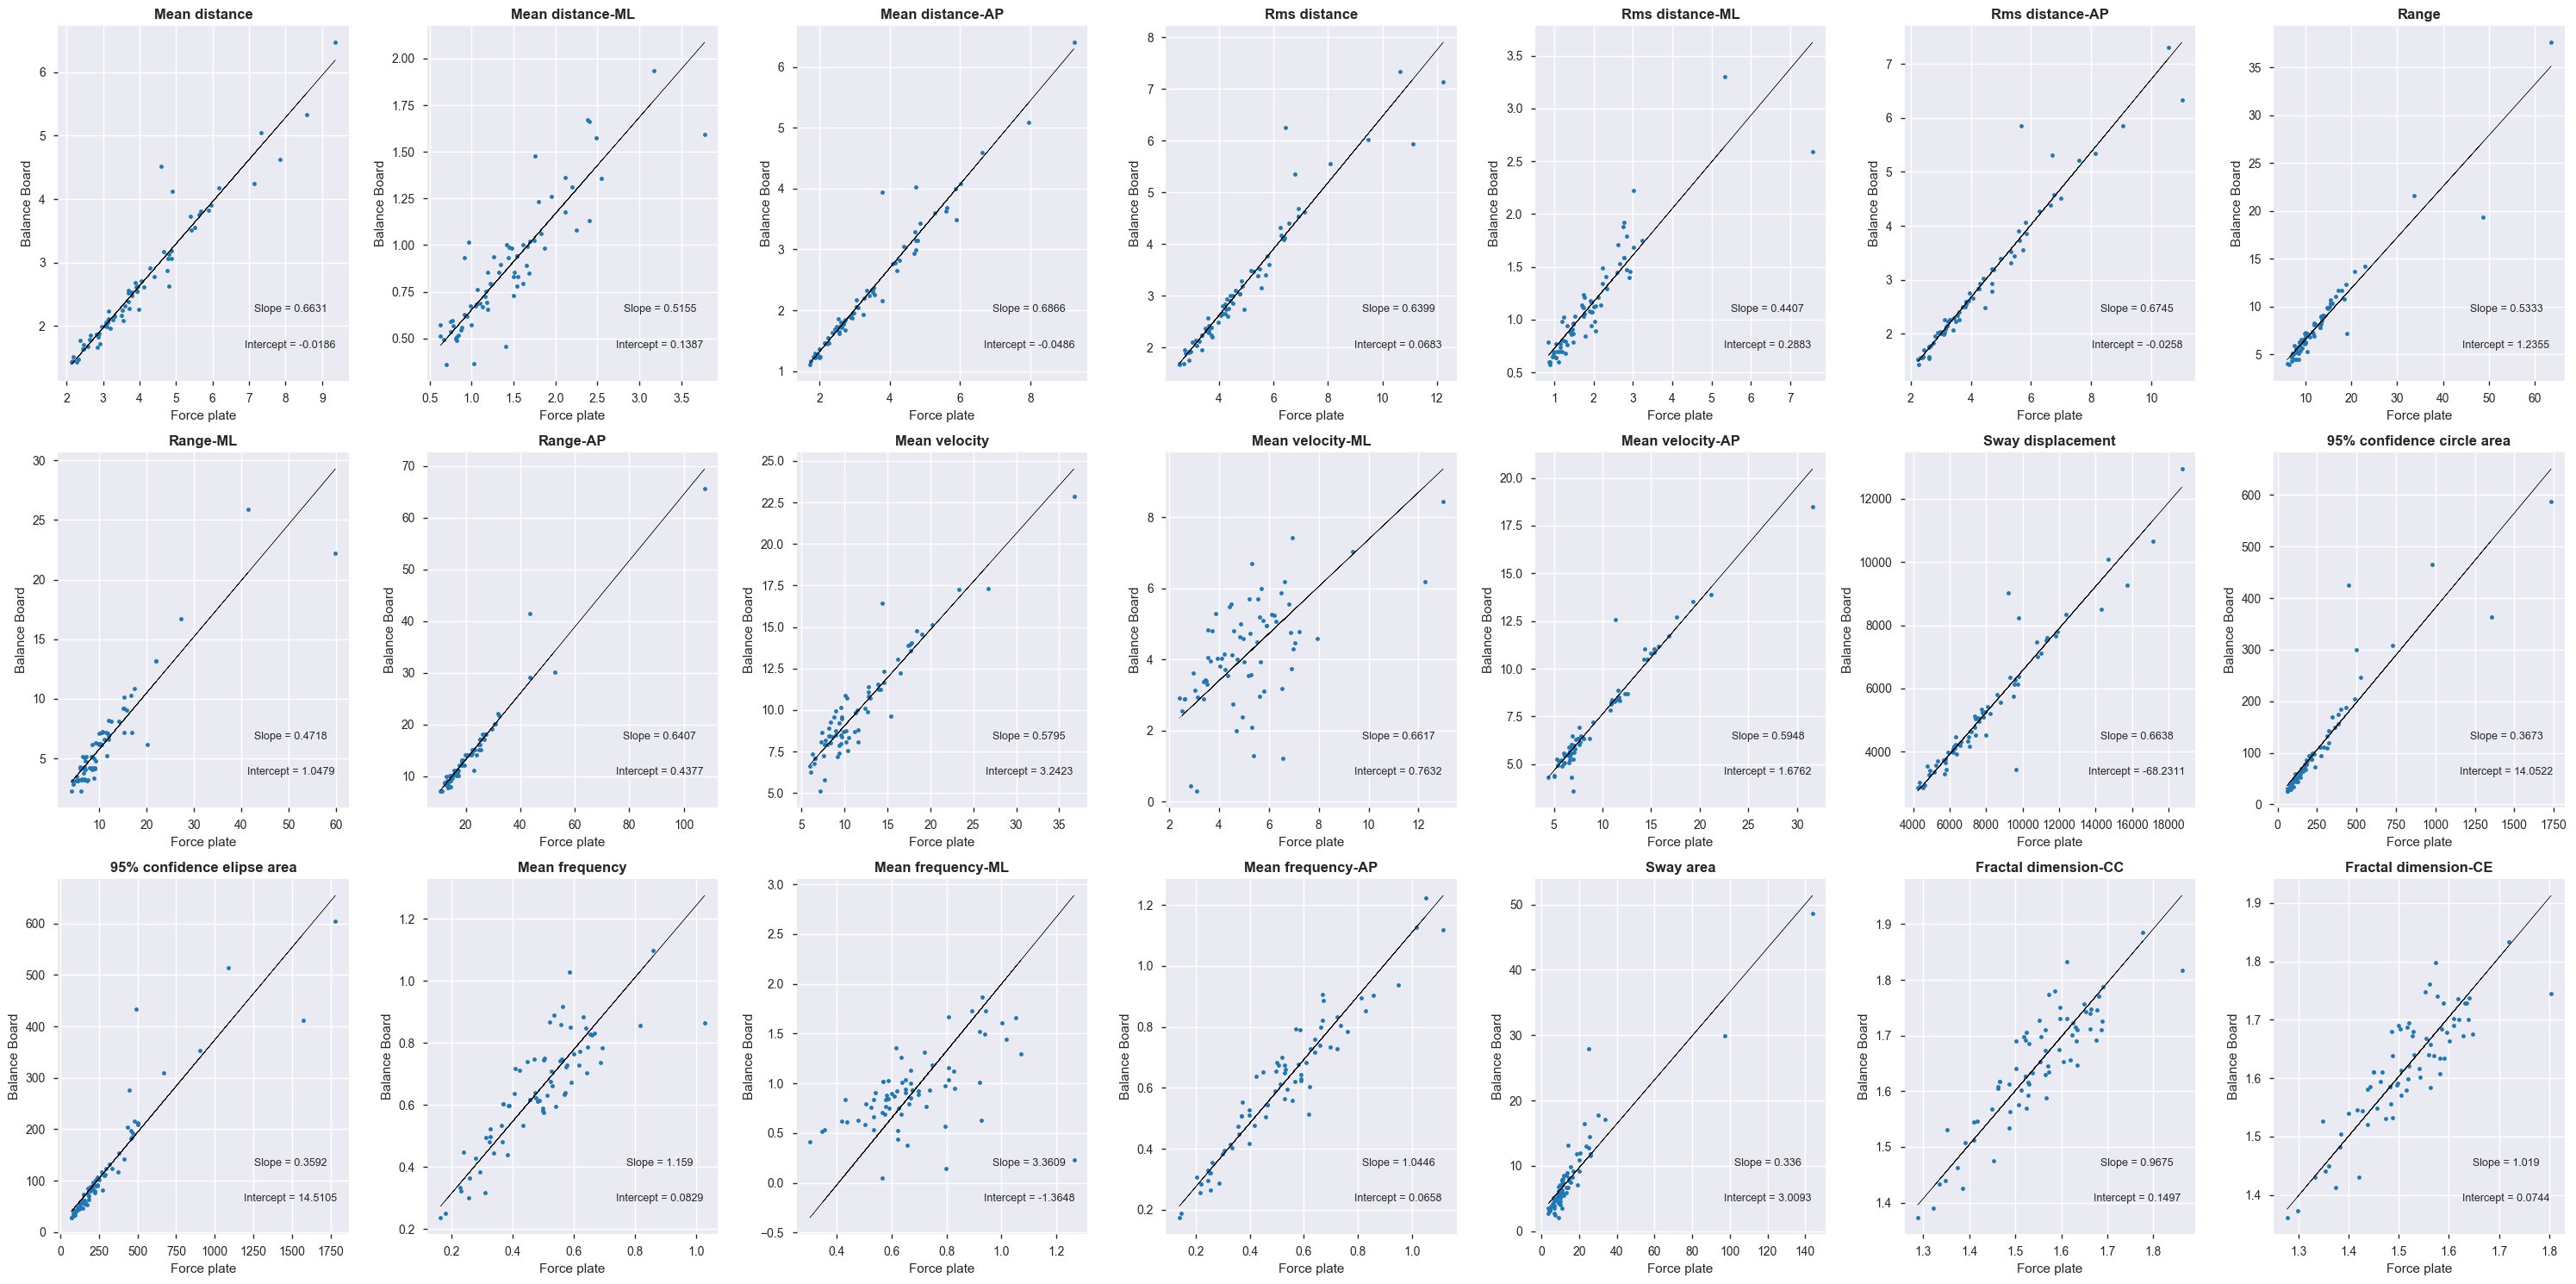

In [49]:
plot_correlation_3(wbb_time, fp_time_cut)

### Bland and Altman plots + LOA (limit of agreement)

In [50]:
def bland_altman_plot(df1, df2, name="time_domain"):
    columns = df1.columns
    fig, axs = plt.subplots(7,3,figsize=(20,30),facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5)
    df1= df1.reorder_levels(['balance board','device','subject','trial']).sort_index()
    df2= df2.reorder_levels(['balance board','device','subject','trial']).sort_index()

    for ax, column in zip(axs.ravel(), columns):
        x = df1[column].values
        y = df2[column].values
        data1 = np.asarray(x)
        data2 = np.asarray(y)
        #mean = np.mean([x, y], axis=0)
        trials = [trial for trial in range(len(data1))]
        diff = x - y 
        md = np.mean(diff)               
        sd = np.std(diff, axis=0)

        ax.scatter(trials, diff, marker='.',s=60, color = "gray",  )
        trials_limits = [x * 18 + 0.5 for x in range(1, 4)]
        for limit in trials_limits:
            ax.axvline(limit,color='black', linestyle='--', linewidth=0.5)

        ax.axhline(md,color='tomato', linestyle='--')
        ax.axhline(md + 2*sd, color='teal', linestyle='--', linewidth=0.5)
        ax.axhline(md - 2*sd, color='teal', linestyle='--', linewidth=0.5)
        ax.set_xlabel('Trials')
        ax.set_ylabel('Difference')
        ax.set_title(column, weight = 600)
        
        #ax.legend()
    plt.savefig("results/{}_bland_altman_plots.png".format(name), bbox_inches='tight')

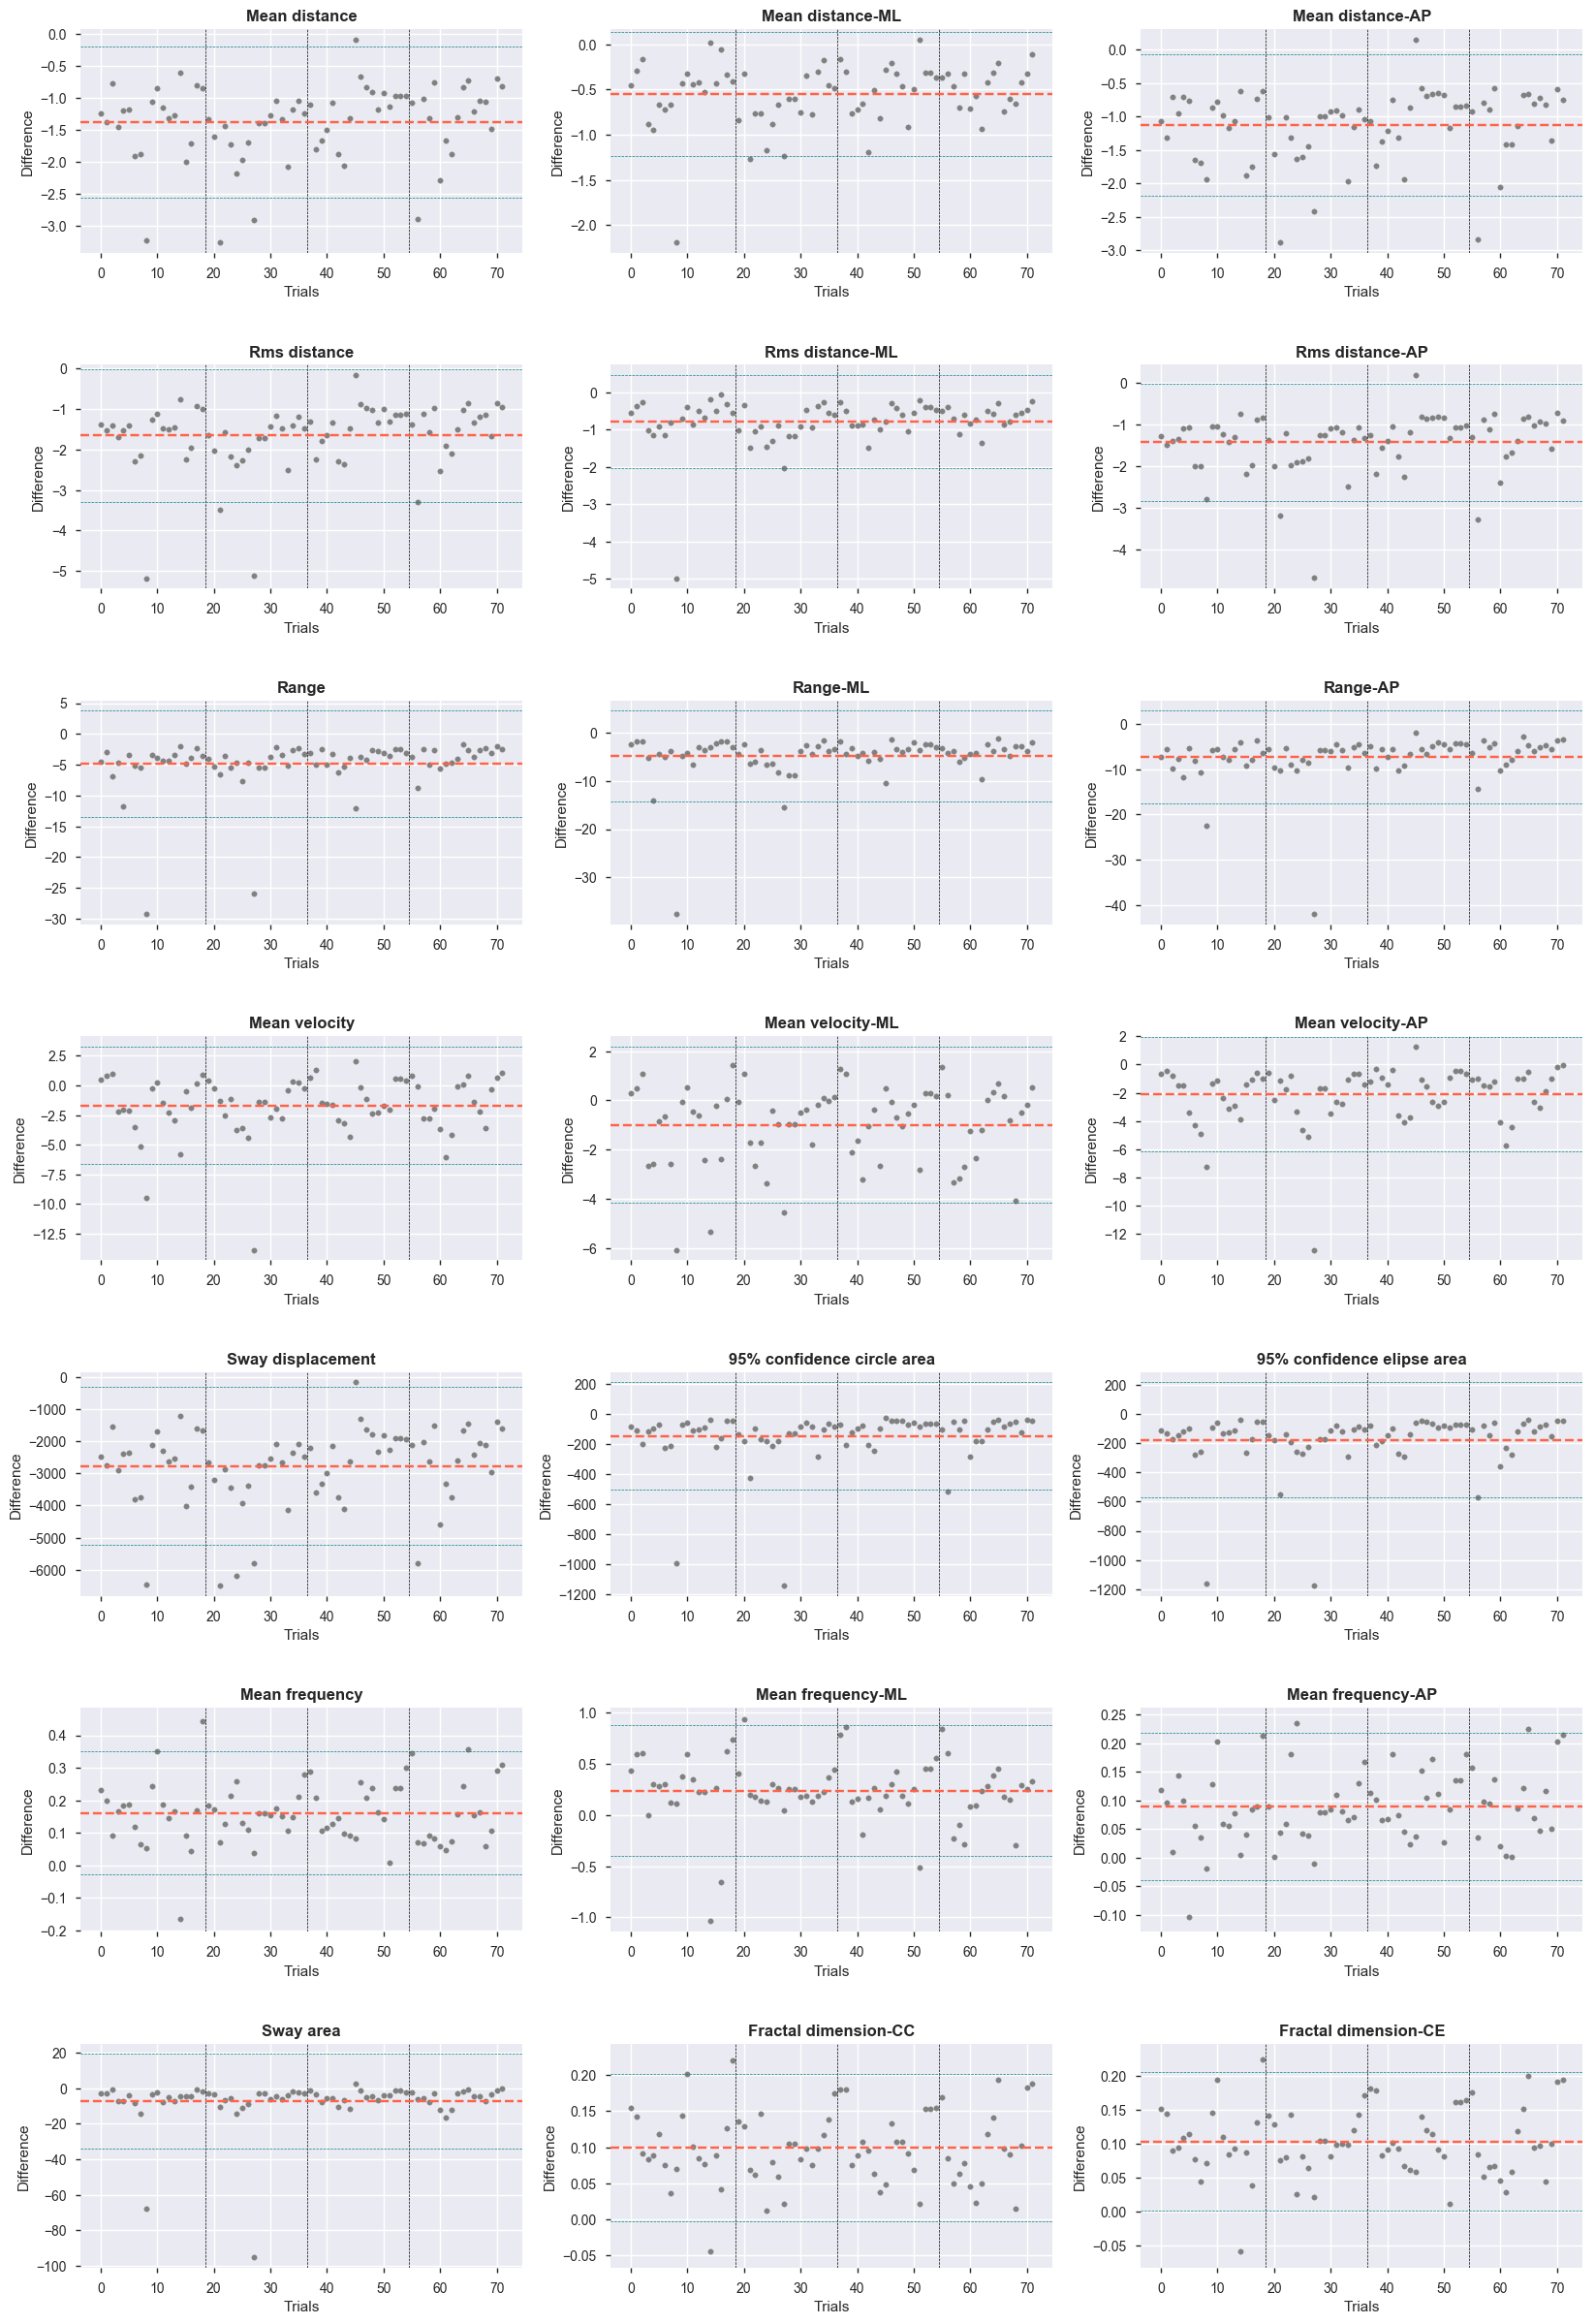

In [51]:
bland_altman_plot(wbb_time,fp_time)

###  Intraclass correlation coefficient (ICC) 



In [52]:
from rpy2.robjects import DataFrame, FloatVector, pandas2ri
from rpy2.robjects.packages import importr

In [53]:
rpy2.__version__

'2.9.5'

In [54]:
def compute_ICC(df1):
    """
    Compute the two-way mixed ICC.

    References
    ----------
    .. [1] R library used for the ICC implementation: http://www.personality-project.org/r/html/ICC.html

    Notes
    -----
    More info on what is the two-way mixed ICC: https://www.uvm.edu/~dhowell/methods8/Supplements/icc/More%20on%20ICCs.pdf
    """

    psych = importr("psych")
    wbb_numbers = ["1", "2", "3", "4"]
    dfs_1 = [df1.loc[(df1.index.get_level_values(3) == number)] for number in wbb_numbers]
    result_dict = {}
    # Loop over each feature
    for column in df1.columns:
        r_df = DataFrame({"WBB 1 feature": FloatVector(dfs_1[0][column]),
                              "WBB 2 feature": FloatVector(dfs_1[1][column]),
                              "WBB 3 feature": FloatVector(dfs_1[2][column]),
                              "WBB 4 feature": FloatVector(dfs_1[3][column])})
        # Compute the two way mixed ICC
        icc_res = psych.ICC(r_df)
        iccs_r_df = icc_res[0]

        iccs_df = pandas2ri.ri2py(iccs_r_df)
        # Select the ICC that corresponds to the 2 way mixed model (see links above)
        icc = iccs_df.iloc[4]["ICC"]
        icc_lower_bound = iccs_df.iloc[5]["lower bound"]
        icc_upper_bound = iccs_df.iloc[5]["upper bound"]
        icc_result = "{}({}, {})".format(round(icc, 4), round(icc_lower_bound, 4), round(icc_upper_bound, 4))

        # Store the results
        result_dict[column] = {}
        result_dict[column]["ICC"] = icc_result

    return result_dict

In [55]:
ICC_results = compute_ICC(wbb_time)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: singular fit

  warnings.warn(x, RRuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [56]:
ICC_results_df = pd.DataFrame.from_dict(ICC_results).transpose()

In [57]:
ICC_results_df

,ICC
Mean distance,"0.7355(0.4577, 0.8899)"
Mean distance-ML,"0.7226(0.4313, 0.8845)"
Mean distance-AP,"0.7473(0.4819, 0.8948)"
Rms distance,"0.7283(0.4431, 0.8869)"
Rms distance-ML,"0.686(0.366, 0.8713)"
Rms distance-AP,"0.7481(0.4837, 0.8952)"
Range,"0.5874(0.1618, 0.8298)"
Range-ML,"0.5857(0.178, 0.8331)"
Range-AP,"0.6351(0.2519, 0.8481)"
Mean velocity,"0.8669(0.727, 0.9446)"


In [58]:
def compute_ICC_2(df1):
    """
    Compute the two-way mixed ICC.

    References
    ----------
    .. [1] R library used for the ICC implementation: https://cran.r-project.org/web/packages/irr/irr.pdf

    Notes
    -----
    More info on what is the two-way mixed ICC: https://www.uvm.edu/~dhowell/methods8/Supplements/icc/More%20on%20ICCs.pdf
    """

    irr = importr("irr")

    wbb_numbers = ["1", "2", "3", "4"]
    dfs_1 = [df1.loc[(df1.index.get_level_values(3) == number)] for number in wbb_numbers]
    dfs_1_mean = [df.groupby([df.index.get_level_values(0),df.index.get_level_values(1),\
                              df.index.get_level_values(3)]).mean() for df in dfs_1]

    result_dict = {}
    # Loop over each feature
    for column in df1.columns:
        r_df = DataFrame({"WBB 1 feature": FloatVector(dfs_1_mean[0][column]),
                              "WBB 2 feature": FloatVector(dfs_1_mean[1][column]),
                              "WBB 3 feature": FloatVector(dfs_1_mean[2][column]),
                              "WBB 4 feature": FloatVector(dfs_1_mean[3][column])})
        # Compute the two way mixed ICC
        icc_res = irr.icc(r_df,"twoway","agreement","average")
        
        result_dict[column] = dict(zip(icc_res.names, list(icc_res)))
        
    return result_dict

In [59]:
ICC_results = compute_ICC_2(wbb_time)

In [60]:
ICC_results_df = pd.DataFrame.from_dict(ICC_results).transpose()

In [61]:
ICC_results_df

,Fvalue,conf.level,df1,df2,icc.name,lbound,model,p.value,r0,raters,subjects,type,ubound,unit,value
Mean distance,[3.3045100305009165],[0.95],[5.0],[16.853954391125882],"[ICC(A,4)]",[-0.04790125431760169],[twoway],[0.029114721013860725],[0.0],[4],[6],[agreement],[0.9570062443304309],[average],[0.7185010806272698]
Mean distance-ML,[8.244602661773351],[0.95],[5.0],[17.997356216560995],"[ICC(A,4)]",[0.58673041172234],[twoway],[0.0003384075237374735],[0.0],[4],[6],[agreement],[0.9806979583835121],[average],[0.8773604983356535]
Mean distance-AP,[3.493787365925795],[0.95],[5.0],[16.78763810100391],"[ICC(A,4)]",[0.013656194980865921],[twoway],[0.023888889406611918],[0.0],[4],[6],[agreement],[0.9595160897619386],[average],[0.7349967673822964]
Rms distance,[2.8643352771250097],[0.95],[5.0],[17.39073643683685],"[ICC(A,4)]",[-0.20813883211827283],[twoway],[0.04616913748514198],[0.0],[4],[6],[agreement],[0.9485362474132507],[average],[0.6656992729180693]
Rms distance-ML,[4.791142378032498],[0.95],[5.0],[17.983154012349846],"[ICC(A,4)]",[0.29422713141600304],[twoway],[0.005860743112698434],[0.0],[4],[6],[agreement],[0.9672383595387442],[average],[0.7915127466310821]
Rms distance-AP,[3.1705895653595944],[0.95],[5.0],[17.283568076920357],"[ICC(A,4)]",[-0.08581717036046518],[twoway],[0.032881634521771105],[0.0],[4],[6],[agreement],[0.9539655460666301],[average],[0.7006872693561219]
Range,[2.661397822862693],[0.95],[5.0],[17.974629817806544],"[ICC(A,4)]",[-0.2675476053745302],[twoway],[0.05706549280083929],[0.0],[4],[6],[agreement],[0.9403384901935964],[average],[0.6217153660815391]
Range-ML,[3.7997043196202966],[0.95],[5.0],[17.968631839954917],"[ICC(A,4)]",[0.10576381022122157],[twoway],[0.01594508381268574],[0.0],[4],[6],[agreement],[0.9570628845266893],[average],[0.7291968641728913]
Range-AP,[2.5733178259931346],[0.95],[5.0],[17.633761827162253],"[ICC(A,4)]",[-0.34039428511405767],[twoway],[0.06413860529391703],[0.0],[4],[6],[agreement],[0.9413463209667058],[average],[0.6213313211467458]
Mean velocity,[14.397440103006874],[0.95],[5.0],[17.829590801838076],"[ICC(A,4)]",[0.7715971825650997],[twoway],[9.967096669770136e-06],[0.0],[4],[6],[agreement],[0.9895111195834618],[average],[0.9330840529075285]
